<a href="https://colab.research.google.com/github/alibekk93/GK_evaluation/blob/main/GK_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [315]:
# essential ones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [316]:
!pip install requests_html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [317]:
import requests
from requests_html import HTMLSession
from bs4 import BeautifulSoup

In [318]:
def convert_age(str_age:str) -> float:
  """Converts age of FBRef format into float, e.g. '12-345' to 12.945
  """

  years, days = (float(s) for s in str_age.split('-'))
  days /= 365
  return years + days

In [319]:
session = HTMLSession()

In [341]:
# get html
r = session.get('https://fbref.com/en/comps/Big5/keepersadv/players/Big-5-European-Leagues-Stats')
soup = BeautifulSoup(r.html.raw_html)
# find table and process data into dataframe
table = soup.findAll('table')[0]
headers = table.find('thead').findAll('tr')[1].text.split('\n')[2:-1]
rows = table.find('tbody').findAll('tr')
data = [r.findAll('td') for r in rows]
data = pd.DataFrame(np.array([row[col].text for row in data for col in range(len(row))]).reshape(-1, 34), columns=headers)
# renaming some columns for better aestetics
data.columns = ['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'Played90s', 'GA',
                'PKA', 'FK', 'CK', 'OG', 'PSxG', 'PSxG_perSoT', 'PSxG_diff', 'PSxG_diff_per90', 'Cmp',
                'Att', 'Cmp_p', 'PassAtt', 'PassThr', 'PassLaunch_p', 'PassAvgLen', 'GKAtt', 'GKLaunch_p',
                'GKAvgLen', 'CrossAtt', 'CrossStp', 'CrossStp%', 'nOPA', 'nOPA_per90', 'AvgDistOPA', 'Matches']
# convert data
data.Age = data.Age.apply(convert_age)
NUMERIC = ['Age', 'Born', 'Played90s', 'GA', 'PKA', 'FK', 'CK', 'OG', 'PSxG', 'PSxG_perSoT', 'PSxG_diff',
           'PSxG_diff_per90', 'Cmp', 'Att', 'Cmp_p', 'PassAtt', 'PassThr', 'PassLaunch_p', 'PassAvgLen',
           'GKAtt', 'GKLaunch_p', 'GKAvgLen', 'CrossAtt', 'CrossStp', 'CrossStp%', 'nOPA', 'nOPA_per90', 'AvgDistOPA']
for col in NUMERIC:
  data[col] = pd.to_numeric(data[col], errors='coerce')

DIVISIBLES = ['Cmp', 'Att', 'PassAtt', 'PassThr', 'GKAtt', 'CrossAtt', 'CrossStp']
for col in DIVISIBLES:
  colName = col + '_per90'
  data[colName] = data[col] / data.Played90s

NUMERIC += [colName + '_per90' for colName in DIVISIBLES]

In [368]:
data_filtered = data[data.Played90s >= 10]
data_filtered = data.dropna()

In [370]:
from sklearn.decomposition import PCA

PCA_COLUMNS = ['PSxG_diff_per90', 'PassAtt_per90', 'PassThr_per90', 'PassLaunch_p', 'PassAvgLen',
               'CrossAtt_per90', 'CrossStp_per90', 'nOPA_per90', 'AvgDistOPA']

X = data_filtered[PCA_COLUMNS]
model_pca = PCA(n_components=2)
data_transformed = pd.DataFrame(model_pca.fit_transform(X))

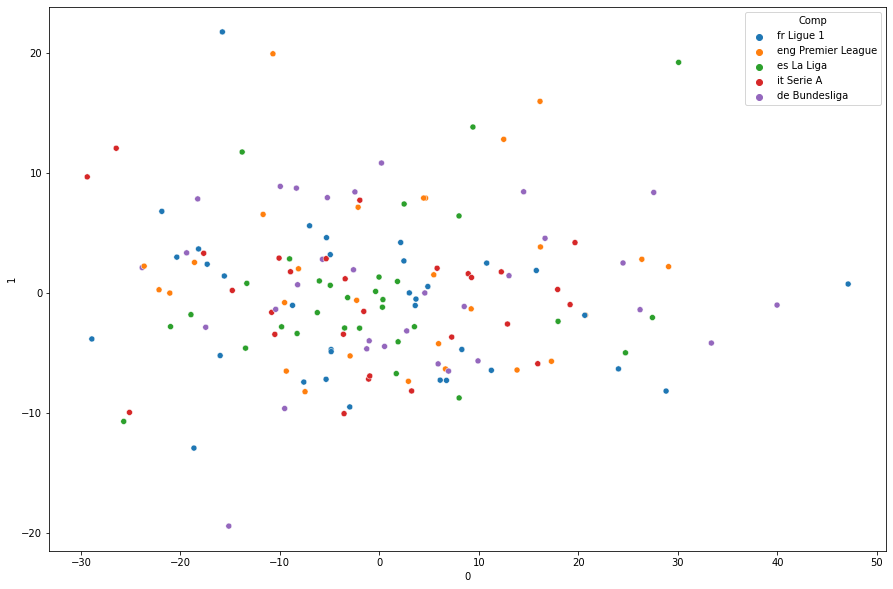

In [374]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x=data_transformed[0], y=data_transformed[1], hue=data_filtered.Comp)